# Prophet, преобразование бокса-кокса

##  Prophet

In [227]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt


#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [5]:
from fbprophet import Prophet

In [6]:
df = data[['PJME_MW']].resample('D').mean().reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2002-01-01,31080.739130
1,2002-01-02,34261.541667
2,2002-01-03,34511.875000
3,2002-01-04,33715.458333
4,2002-01-05,30405.125000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6059 entries, 0 to 6058
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      6059 non-null   datetime64[ns]
 1   y       6059 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 94.8 KB


In [73]:
df[-2000:].tail()

,ds,y
6054,2018-07-30,32957.416667
6055,2018-07-31,34539.083333
6056,2018-08-01,39230.791667
6057,2018-08-02,39593.041667
6058,2018-08-03,35486.000000


In [172]:
n = 365
m = Prophet(yearly_seasonality = True, 
           weekly_seasonality= True, 
#             seasonality_mode='multiplicative',
# #             interval_width = 0.95,
              seasonality_prior_scale= 500000000
       )
m.fit(df[-1365:-n])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
future = m.make_future_dataframe(periods=n)
future.tail() #создаем даты для предсказания

,ds
1360,2018-07-30
1361,2018-07-31
1362,2018-08-01
1363,2018-08-02
1364,2018-08-03


In [174]:
forecast = m.predict(future)
forecast = forecast.merge( df, how = 'left', on = 'ds')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']].tail()

,ds,yhat,yhat_lower,yhat_upper,y
1360,2018-07-30,37353.941292,33395.978596,41047.320562,32957.416667
1361,2018-07-31,37780.027213,33988.027928,41602.058448,34539.083333
1362,2018-08-01,37388.873712,33363.808381,40951.815138,39230.791667
1363,2018-08-02,37123.450893,33224.184709,40708.436324,39593.041667
1364,2018-08-03,37074.162198,33337.794835,40627.379802,35486.000000


In [175]:
df_check = forecast[-n:]
print('MAE {}'.format( np.abs(df_check['yhat'] - df_check['y']).mean() ))
print('MAPE: {}'.format((np.abs(df_check['yhat'] - df_check['y'])/df_check['y']).mean()))

MAE 3010.2622577979823
MAPE: 0.09396239318231236


y_hat - наше предсказание. y_lower и yhat_upper - верхняя и нижняя граница предсказания

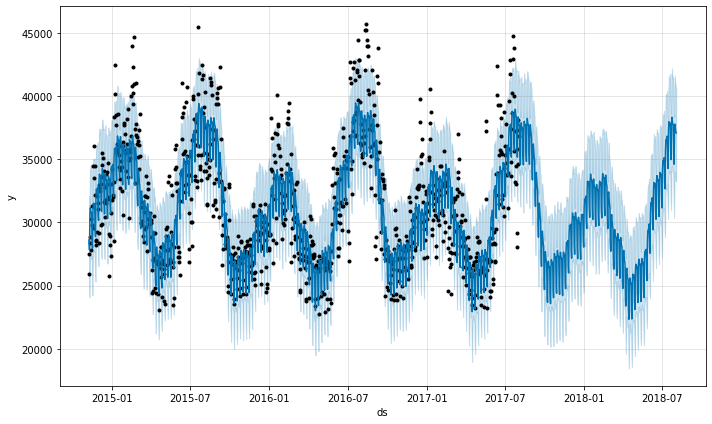

In [176]:
fig1 = m.plot(forecast)

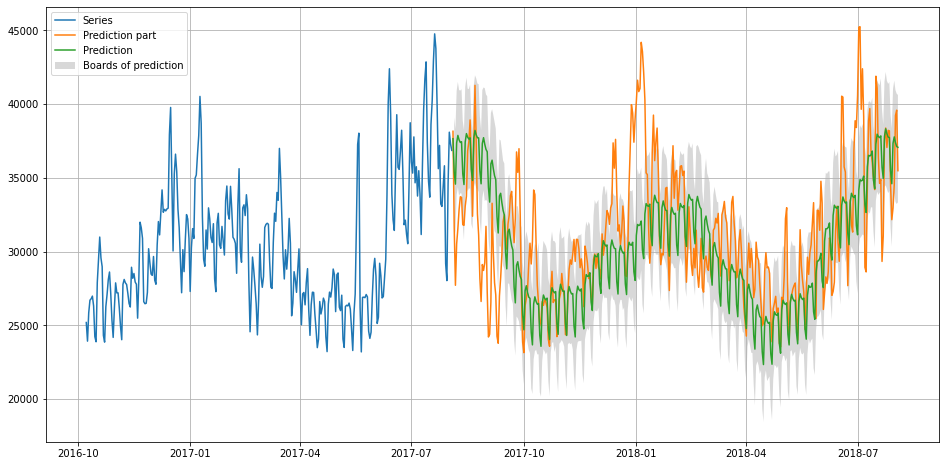

In [189]:
x = forecast.set_index('ds').index
plt.figure(figsize = (16,8))
plt.plot(df.set_index('ds')[-n-300:-n], label = 'Series')
plt.plot(df.set_index('ds')[-n:], label = 'Prediction part')
plt.plot(forecast.set_index('ds')['yhat'][-n:], label = 'Prediction')
plt.fill_between(x, forecast.set_index('ds')['yhat_lower'], forecast.set_index('ds')['yhat_upper'],
                facecolor='grey', alpha=0.3,  where=(x > df.set_index('ds')[-n:].index[0]), label = 'Boards of prediction')
# ax.fill_between(x, 0, pdf, facecolor='red', alpha=0.5,  where=(x < left))
plt.grid()
plt.legend()

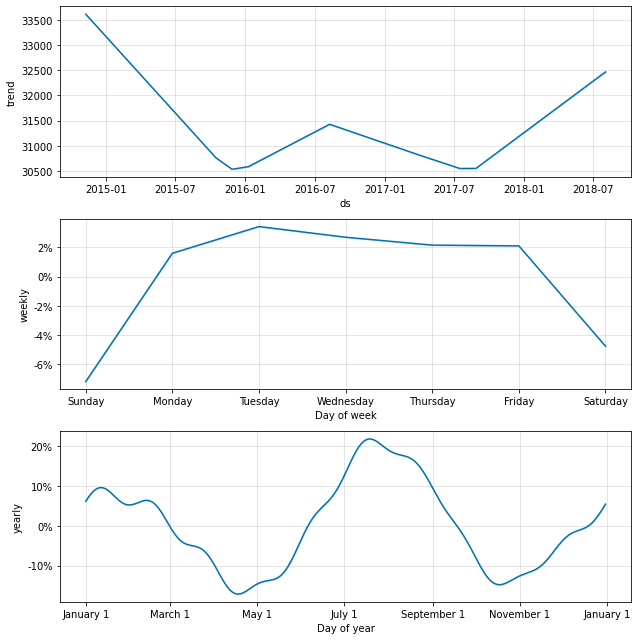

In [167]:
fig2 = m.plot_components(forecast)

Можно добавлять дополнительные регрессоры, которые будут помогать делать предсказывание. 

Примеры ноутбуков, где разбираются все возмжности этой модели тут https://github.com/facebook/prophet/tree/master/notebooks

## Преобразование Бокса -Кокса

In [226]:
from scipy import stats

In [197]:
path_retail = 'example_retail_sales.csv'
data = pd.read_csv(path_retail, index_col=[0], parse_dates=[0])

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 1992-01-01 to 2016-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       293 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB


In [200]:
data['y'].isnull().sum()

0

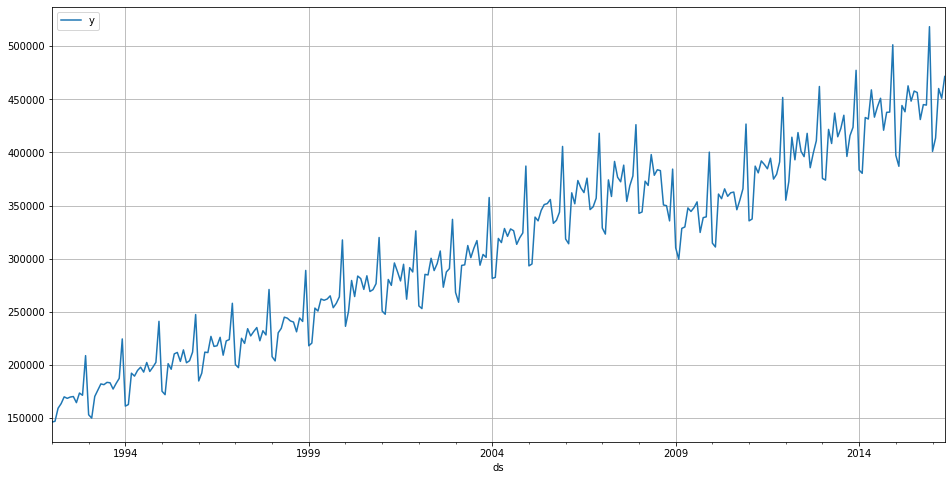

In [203]:
data.plot(figsize = (16,8))
plt.grid()

In [207]:
data

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068
...,...
2016-01-01,400928
2016-02-01,413554
2016-03-01,460093


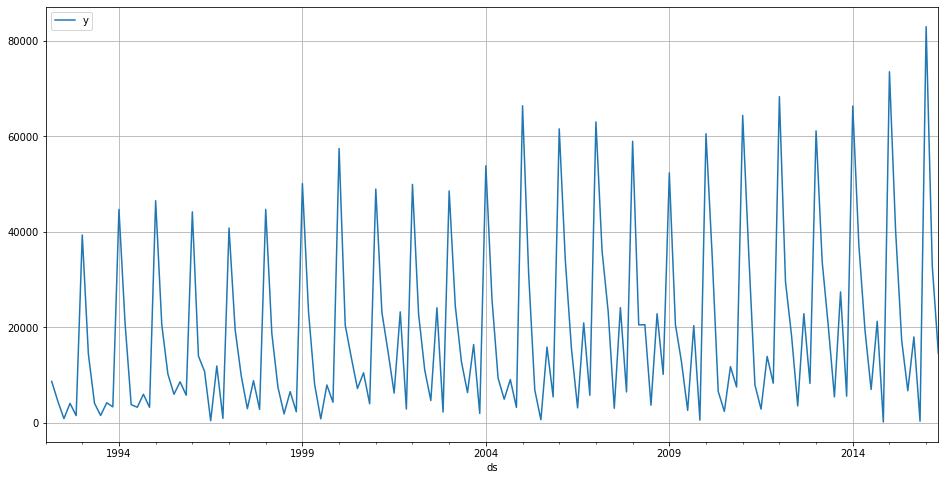

In [218]:
data.resample('2M').std().plot(figsize = (16,8))
plt.grid()

Преобразование Бокса-Кокса помогает нам стабилизировать дисперсию

In [221]:
data['y_box_cox'] = stats.boxcox(data['y'])[0]

lambda_max_log = round(stats.boxcox(data.y)[1], 4)

def invboxcox(y, lmbd):
    if lmbd == 0:
        return np.exp(y)
    else:
        return np.power(lmbd * y + 1, 1.0 / lmbd)

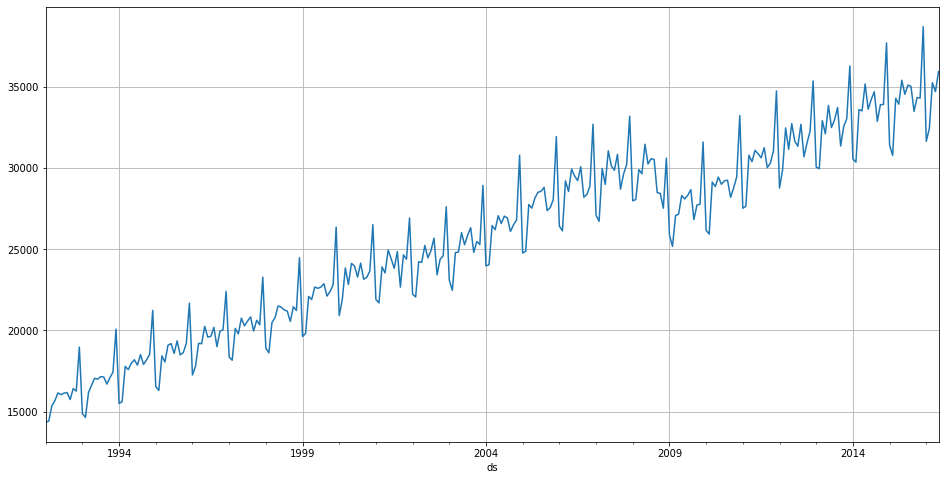

In [224]:
data.y_box_cox.plot(figsize = (16,8))
plt.grid()

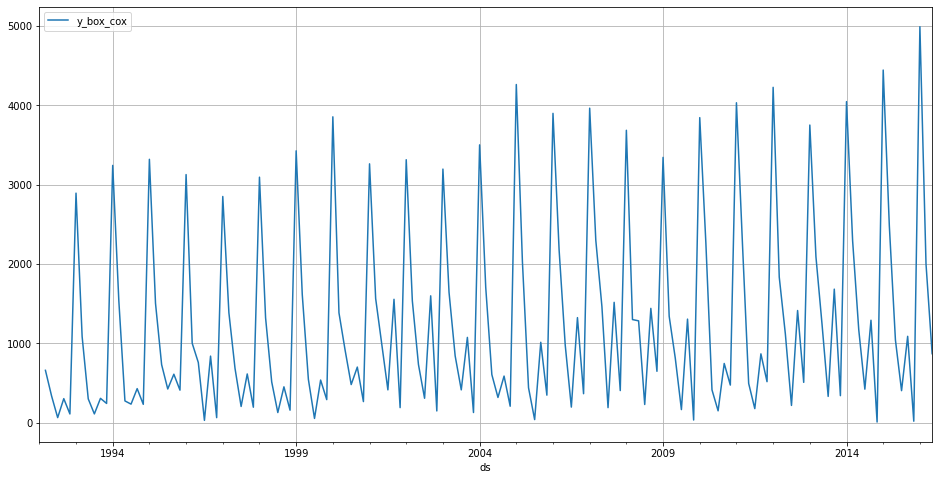

In [225]:
data[['y_box_cox']].resample('2M').std().plot(figsize = (16,8))
plt.grid()

# Декомпозиция. Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [237]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [272]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

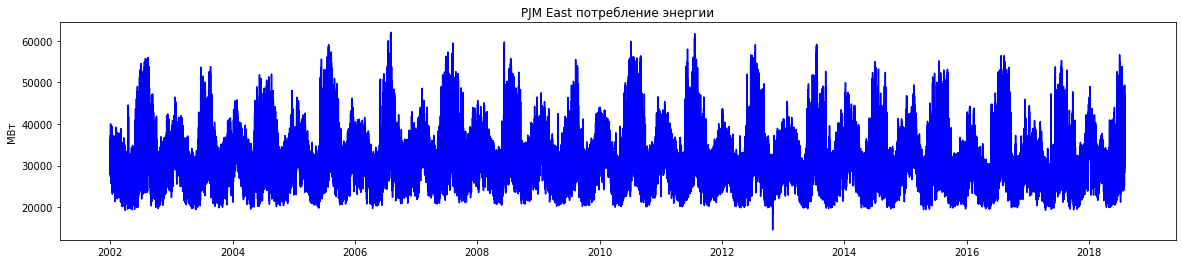

In [273]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

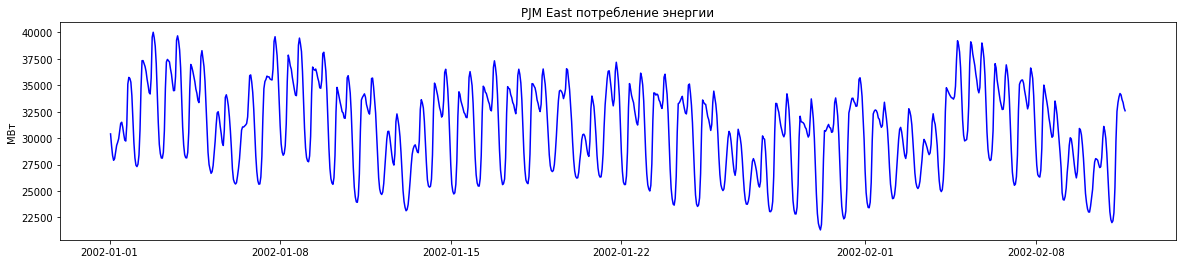

In [274]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index[:1000], data['PJME_MW'].iloc[:1000], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

Выделим тренд и циклы.

1) Тренд:
    - перписывем модель в точки с координатами х1=i-номер измерения, y=значению потребления
    - строим модель y = w1*x1+w0

32079.773047450024 -0.009426799102881998


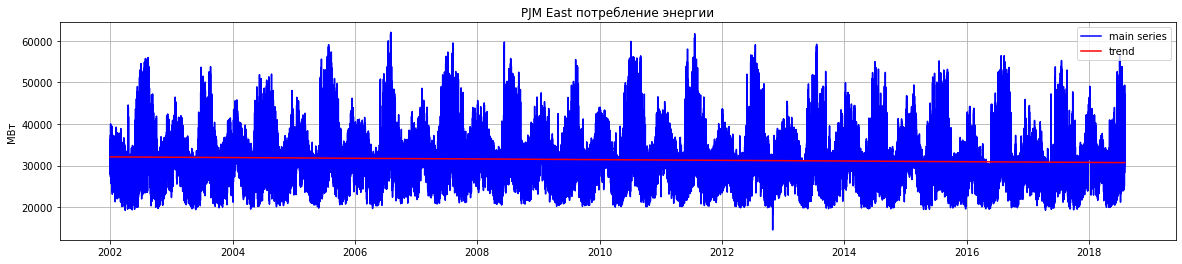

In [322]:
from sklearn.linear_model import LinearRegression

y= data['PJME_MW'].values
x1 = np.array(range(data.shape[0]))

Lin_mod = LinearRegression()
Lin_mod.fit(x1.reshape(-1, 1),y.reshape(-1, 1))

W1 =Lin_mod.coef_[0,0]
W0 =y.mean()
print(W0,W1)

plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' , label ='main series')
plt.plot( data.index[[0,-1]], [W0+W1*x1[0] , W0+W1*x1[-1]], 'r',label='trend' )
plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

Убираем тренд и переходим к поиску циклов.

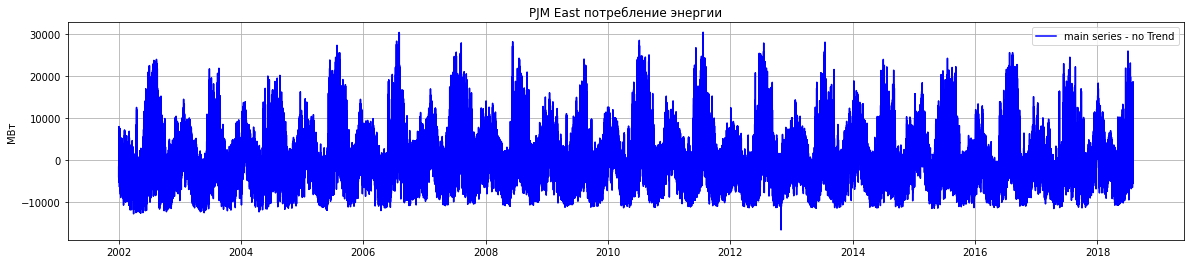

In [323]:
y_no_trend = data['PJME_MW'] - W0-W1*x1

plt.figure(figsize =(20,4))
plt.plot( data.index,y_no_trend, 'b' , label ='main series - no Trend')

plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

2) Знаем из ACF, что цикл где-то 12 месяцев(52-53 недели, 365-366 дней). В часовом исполнении это будет 365(+/-1)*24  . Проверяем отклонения для этих данных. 

In [324]:
delta_range = range(365*24,366*24)
stdi=[]
for delta in delta_range:
# свдигаем ряд на лаг и считаем отклонения. Они должны быть минимальны
    stdi.append(np.std(y_no_trend[delta:]-y_no_trend[:-delta])) 
tab_=pd.DataFrame(data=stdi,index=delta_range)
season = tab_[tab_[0]== tab_[0].min()].index[0]
print('Длина годового цикла = ',season   )

Длина годового цикла =  8760


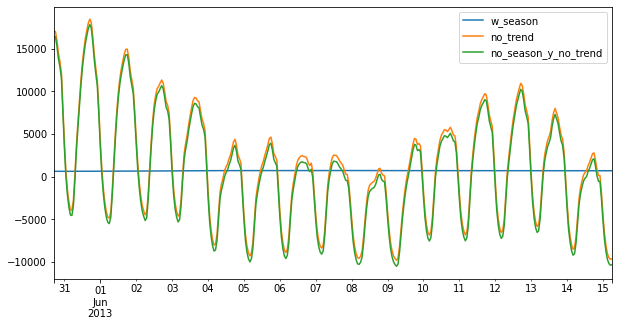

In [325]:
# снимаем составляющую из годового сдвига (вычитаем среднюю по длине цикла из ACF)
# без тренда
y_no_trend_no_season = pd.DataFrame(data=y_no_trend, index =data.index, columns =['no_trend'])
y_no_trend_no_season['no_trend'] = data['PJME_MW'] - (W0+W1*x1)
# тренд
y_no_trend_no_season['trend'] = W0+W1*x1
# сезонные аддитивные сдвиги
y_no_trend_no_season['no_season_y_no_trend'] = y_no_trend_no_season['no_trend']- \
                                        y_no_trend_no_season['no_trend'].rolling(season).mean()

y_no_trend_no_season['no_trend'].rolling(season).mean()[100000:-45000].plot(label = 'w_season', figsize = (10,5))
y_no_trend_no_season['no_trend'][100000:-45000].plot(label = 'no_trend')
y_no_trend_no_season['no_season_y_no_trend'][100000:-45000].plot(label = 'no_season_y_no_trend')
plt.legend()

In [326]:
# определяем потенциальную дилну сезонного цикла в месяцах цикла (число дней месяца умножим на число часов = длина месяца в часах)
delta_range = range(27*24,31*24)

#подбор по параметру лучшей средней абсолютной разницы
s_i=[]
for delta in delta_range:
    s_i.append(np.mean(y_no_trend_no_season['no_season_y_no_trend']-y_no_trend_no_season['no_season_y_no_trend']\
                                                                                      .rolling(delta).mean()))
tab_f=pd.DataFrame(data=s_i,index=delta_range,columns=['add'])
season_f = tab_f[tab_f['add']== tab_f['add'].min()].index[0]
season_f

694

In [327]:
694/24

28.916666666666668

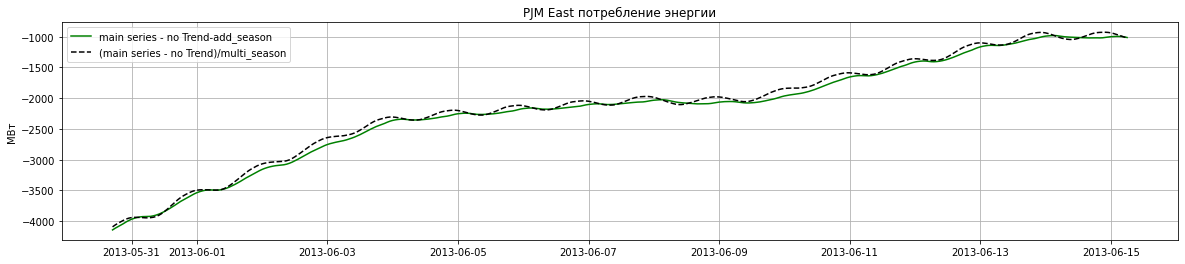

In [328]:
#подбор для мультипликативной модели (средний индекс должет быть 1)
delta_range = range(27*24,31*24)
s_i=[]
for delta in delta_range:
    s_i.append(np.mean(y_no_trend_no_season['no_season_y_no_trend']/y_no_trend_no_season['no_season_y_no_trend']\
                       .rolling(delta).mean()))
tab_f['multi_season']=np.array(s_i)
season_fm = tab_f[tab_f['multi_season']== tab_f[(tab_f.multi_season>0) &
                                                (tab_f.multi_season<=1)].multi_season.max()].index[0]

# порисуем
plt.figure(figsize =(20,4))
# plt.plot( data.index[100000:-45000],y_no_trend_no_season['no_trend'][100000:-45000], '--b' , label ='main series - no Trend')
# plt.plot( data.index[100000:-45000],y_no_trend_no_season['no_season_y_no_trend'][100000:-45000], '--r' , label ='main series - no Trend-season')
plt.plot( data.index[100000:-45000],y_no_trend_no_season['no_season_y_no_trend'].rolling(season_f).mean()[100000:-45000], 'g' , label ='main series - no Trend-add_season')
plt.plot( data.index[100000:-45000],y_no_trend_no_season['no_season_y_no_trend'].rolling(season_fm).mean()[100000:-45000], '--k' , label ='(main series - no Trend)/multi_season')


plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

Построили тренд и варианты сезонной модели. Однако похоже, что аддитивный сезон не рабочий. Берем мультипликативный сезон и покажем, какие варианты лучшие (среднее частное ближе к 1)

In [329]:
tab_f.loc[np.abs(tab_f['multi_season']-1)<0.1]

,add,multi_season
669,0.849977,0.946202
683,1.015687,0.990550
717,0.934652,0.930987


лучший вариант по мультипликативному сезону: 683 часа

In [332]:
683/24

28.458333333333332

In [333]:
season_fm

683

Уберем сезонную составляющую

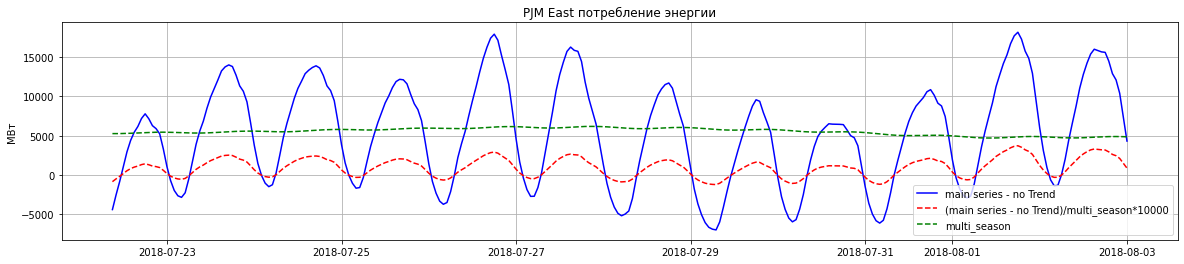

In [334]:
y_season=y_no_trend_no_season['no_season_y_no_trend'].rolling(season_fm).mean()
# y_season[np.where(np.abs(y_season)<np.mean(np.abs(y_season))*0.001)[0]]=np.mean(np.abs(y_season))
# запишем сезонную составляющую
y_no_trend_no_season['season_m'] = y_season
# сохраним остатки без сезона и тренда
y_no_trend_no_season['no_trend_no_season_y_m'] = y_no_trend_no_season['no_season_y_no_trend']/y_season

y_no_trend_no_season['add_season'] =  y_no_trend_no_season['no_trend'].rolling(season).mean()



plt.figure(figsize =(20,4))

plt.plot( data.index[-280:],y_no_trend_no_season['no_season_y_no_trend'][-280:], 'b' , label ='main series - no Trend')
plt.plot( data.index[-280:],y_no_trend_no_season['no_trend_no_season_y_m'][-280:]*1000 , '--r' , label ='(main series - no Trend)/multi_season*10000')
plt.plot( data.index[-280:],y_season[-280:], '--g' , label ='multi_season')


plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

In [335]:
y_no_trend_no_season.tail()

,no_trend,trend,no_season_y_no_trend,season_m,no_trend_no_season_y_m,add_season
2018-08-02 20:00:00,13347.591311,30709.408689,12904.135352,4904.458406,2.631103,443.455960
2018-08-02 21:00:00,12546.600738,30709.399262,12102.460694,4906.357123,2.466690,444.140044
2018-08-02 22:00:00,10842.610165,30709.389835,10397.661950,4901.926141,2.121138,444.948215
2018-08-02 23:00:00,7790.619592,30709.380408,7344.879530,4889.839114,1.502070,445.740062
2018-08-03 00:00:00,4776.629019,30709.370981,4330.160694,4870.649667,0.889031,446.468324


In [307]:
one = y_no_trend_no_season['no_trend_no_season_y_m']*y_no_trend_no_season['season_m']
two = one+y_no_trend_no_season['add_season']
three = two+y_no_trend_no_season['trend']

Итак ряд состоит из:
 - тренд y1=y_no_trend_no_season['trend']
 - сезон y2=y_no_trend_no_season['season']
 - остатки y3=y_no_trend_no_season['no_trend_no_season']
 
 Ряд можно собрать назад:
 
 y3*y2+y1

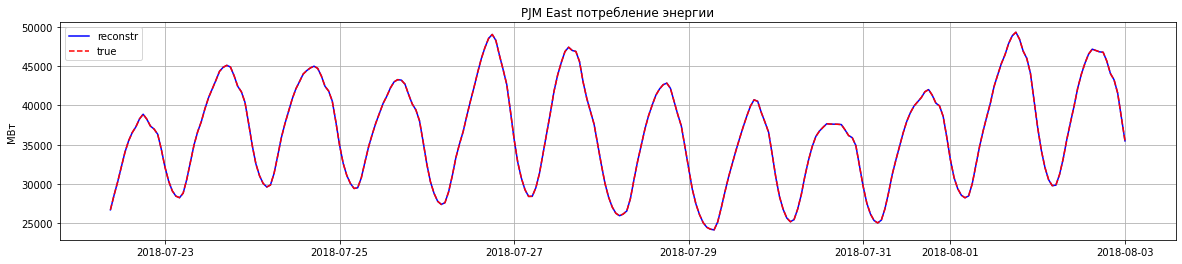

In [308]:
plt.figure(figsize =(20,4))
plt.plot( data.index[-280:],three[-280:]  , 'b' , label ='reconstr')
plt.plot( data.index[-280:],data['PJME_MW'].iloc[-280:] , '--r' , label ='true')



plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ('МВт')
plt.show()

Обратная операция прошла штатно, т.е. собрали ряд обратно и можно строить модели по каждой части отдельно. 

Посмотрим на анамалии, и поищем их в ряду потребление энергии.

# Временные ряды 5. Поиск аномалий и особенные случаи обработки  

Временные ряды - процесс, который идет шаг за шагом. Порядок постоянен или предсказуем. Однако, иногда что-то идет не так. Котенок не  бегает за бантиком. Вопрос - это только сегодня или теперь так будет всегда? Если всегда, то идем менять модель (кот вырос). Если только сейчас, то это аномалия. Аномалии интересны, но опасны.

Попробуем разобраться аномалиями. Вспомним пример аварии в потреблении энергии и попробуем его узнать автоматически.      



Наша цель лежит между 2012 и 2014 годом. Интуитивно понятно, что дело в уровне. Начнем с постановки задачи.



## Задача обнаружения аномалий ##

Для заданного множества объектов необходимо получить множество-исключение. 

С точки зрения временных рядов мы получаем следующее представление:
- Х - вектор наблюдения состоит из измерений временного ряда, а его длина соответствует ширине окна анализа.
- отклонение статистической характеристики вектора от остальных векторов можно считать аномалией. 


Основные задачи:
1.  Задача  распознавания  аномалий,  вытекающих  из  контекста  наблюдаемого  процесса.
2.  Задача  выделения  аномальных  участков  и  дифференциация  аномалий  от  шумов.
3.  Задача  распознавания  аномалий  путем  сравнения  идеальных  и  реальных  процессов.


**Типы аномалий**

Если анализировать только случайную компоненту, то многие аномалии можно свести к одному из следующих случаев:

***Выброс в данных временного ряда.*** Существенное амплитудное изменение ряда на коротком интервале. Классическая задача - работает правило трех сигм, межквартильный размах и другие.

***Изменение характера (распределения) значений.*** Движения временного ряда, связанные с редко происходящими событиями, имеющие скачкообразный характер и меняющие тенденцию. Эту часть предсказывать без внешней информации затруднительно.

***Отклонение от «повседневного» (для данных с циклом)*** Сравниваем текущий период и несколько предыдущих и оцениваем разницу. 

**Основные подходы к поиску аномалий**

- ***Метод  скользящего  окна***.  Ряд  разбивается  на  участки  (окна). Поиск  аномальной  подпоследовательности  осуществляется  при  помощи  скольжения  окна  по  всему  ряду  с  шагом  меньшим  длины  окна  ( размер  окна  нужно подобрать в эксперименте или задать на основе опыта,  увеличение  размера и числа окон  быстро повышают  вычислительную  сложность  алгоритма).  Метод  является  самым  универсальным,  и  применим  для  любых  типов рядов.


- ***Кластеризация***. Строит группировки измерений. Нет  представления  о  точности  границ  аномалий, пропускает  незначительные  аномалии. Универсальный  метод  поиска  аномалий.


- ***Статистические  методы***.  Используют  критерии  для  проверки  гипотез  о  сходстве  или  различии  двух  выборок.  Корреляционный  анализ между частями ряда может  служить  для  анализа  аномальности.  Хорошо работает в задачах  поиска  аномалий  в  физических  процессах. Анализ путём поиска представителей, которые меньше подходят к остальному набору данных.  

- ***Обнаружение аномалий основанное на модели регрессии временного ряда***. Наложив модель на данные, можно спрогнозировать тенденции, а затем проверить, все ли показатели соответствуют им. Для этого нужно сравнить спрогнозированные и фактические показатели. Значительная разница укажет на отклонение или аномалию.

 
- ***Выявления аномалий с учителем***. Требует предоставления данных, помеченных как «нормальные» и «ненормальные», и использует обучение классификатора (выборка очень несбалансирована). 


Посмотрим как применить различные техники поиска аномалий к нашему ряду. Разберем ряд на вектора и определим параметры распределения.

## Оценим поведение ряда. 

Прямолинейный подход: взять среднее всего ряда и вычесть его. Посмотреть на среднее вдоль этого ряда и стандартное отклонение, и попробовать что-то увидеть.
    
У такого линейного подхода проблемах лежат в рамках анализа неоднородных рядов, напрмимер мультипликативный тренд или мультипликативный сезон. Хотя такой полход тоже несет информацию: выбрав расчетные границы, посмотреть что за них убегает и назвать это аномалией

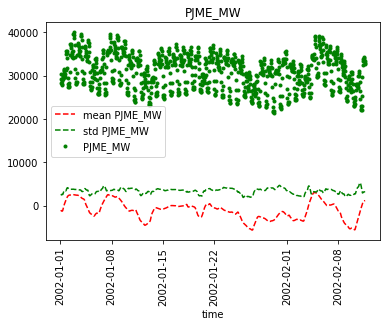

In [147]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1
mean_d=[]
std_d=[]

MeanT=np.mean(data['PJME_MW'])

for i in range(1000):
    d = data['PJME_MW'].iloc[i:i+w] - MeanT
    mean_d.append(np.mean(d))
    std_d.append(np.std(d))
plt.plot(data['data_time'].iloc[:1000],mean_d,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[:1000],std_d,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[:1000],data['PJME_MW'].iloc[:1000],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.legend()
plt.xlabel('time')
plt.xticks(rotation='90')
plt.show()

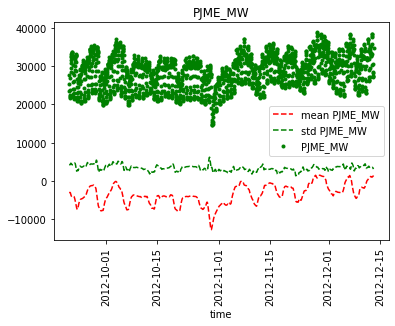

In [148]:
#размер окна  (в часах)
w = 24

#шаг окна  (в часах)
step_w= 1

T=24*365*11-24*100
mean_da=[]
std_da=[]
for i in range(2000):
    da = data['PJME_MW'].iloc[T+i:T+i+w] - MeanT
    mean_da.append(np.mean(da))
    std_da.append(np.std(da))
std_da = np.array(std_da)
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

На графике виден провал (ураган?). Кроме провала в основном ряду виден всплеск в ряду стандартных отклонений и провал в ряду средних. Можно построить простой тест: сглаживание - 1 день, D = |std_da[j]-mean[std_a]| > std_porog. Порог подберем по известной аномалии. В итоге получили метку для аномалии. Можем рассчитывать, что и другие аномалии найдем. Порог определен по разбросу стандартных отклонений ряда std_da (стандартное отклонение для стандартного отклонения), а коэффициент (80) результат подбора по известному факту аномалии.

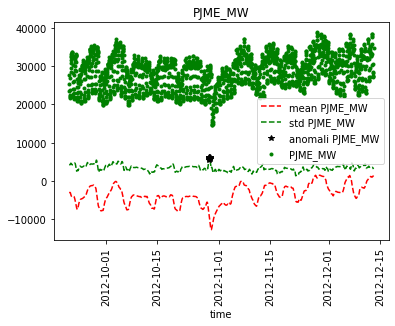

In [149]:
# порог - подобрали по известной аномалии
porog_ = np.abs(std_da - np.mean(std_da)) > (np.std(std_da)**0.5)*80
ind_ = np.where(porog_==1)[0]
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T][ind_],std_da[ind_],'*k',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Поиск аномалий подобным образом основан на прецедентах и может быть реализован как классификатор, если есть разметка. 

## Скользящее окно

Очевидно, что средняя во времени может изменяться. Таким образом имеет смысл смотреть на сглаженные модели ряда  или на скользящие средние, которые позволяют моделировать основные тенденции ряда, его сезонность(цикличность) с тем, чтобы увидеть истинные статистические характеристики конкретного отрезка ряда. Сделаем сглаживание по среднему на дневные интервалы и месячные циклы сезона.

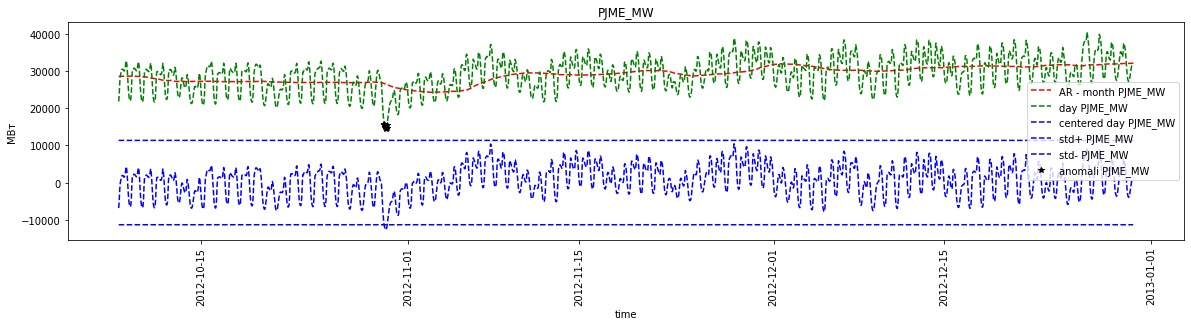

In [162]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1

data_m=data['PJME_MW'].rolling(w*30).mean()
diff_day = data['PJME_MW']#-data_m
data_d=data['PJME_MW'].rolling(w*7).mean()
#data_d[np.where(np.abs(data_d)<0.0001)[0]]=data_d.mean()
diff_day_month=diff_day-data_m
sigma3_diff_day_month = diff_day_month.std()*2

porog_ = np.abs(diff_day_month[-51000:-49000]) > sigma3_diff_day_month 
ind_ = np.where(porog_==1)[0]

plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'*k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()


## Кластеризация

Добавим ряду первые разности в набор данных и сделаем историческое описание размером p.

In [163]:
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

from sklearn.cluster import KMeans, DBSCAN

In [164]:
data['stat'] = diff_day_month

p =3

#добавляем историю длиной р
for i in range(p):
    data['t'+str(p-i+1)]=0
    data['t'+str(p-i+1)].values[p+2:] = data['PJME_MW'].values[i+1:-(p-i+1)]
for i in range(p):
    data['d'+str(p-i+1)]=0    
    data['d'+str(p-i+1)].values[i+1:] = (data['PJME_MW'].values[i+1:]- data['PJME_MW'].values[i:-1])/data['PJME_MW'].values[i:-1]
data.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,data_time,stat,t4,t3,t2,d4,d3,d2
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,2002-01-01 01:00:00,NaN,0,0,0,0,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,2002-01-01 02:00:00,NaN,0,0,0,0,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,2002-01-01 03:00:00,NaN,0,0,0,0,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,2002-01-01 04:00:00,NaN,0,0,0,0,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,2002-01-01 05:00:00,NaN,0,0,0,0,0,0
2002-01-01 06:00:00,28654.0,2002,1,1,1,1,1,1,6,1,0,0,2002-01-01 06:00:00,NaN,29265,28357,27899,0,0,0
2002-01-01 07:00:00,29308.0,2002,1,1,1,1,1,1,7,1,0,0,2002-01-01 07:00:00,NaN,28357,27899,28057,0,0,0
2002-01-01 08:00:00,29595.0,2002,1,1,1,1,1,1,8,1,0,0,2002-01-01 08:00:00,NaN,27899,28057,28654,0,0,0
2002-01-01 09:00:00,29943.0,2002,1,1,1,1,1,1,9,1,0,0,2002-01-01 09:00:00,NaN,28057,28654,29308,0,0,0
2002-01-01 10:00:00,30692.0,2002,1,1,1,1,1,1,10,1,0,0,2002-01-01 10:00:00,NaN,28654,29308,29595,0,0,0


In [165]:
X = data.drop(['data_time'],axis=1).iloc[p+2:,1:].values

In [166]:
Xscale = scl.fit_transform(X[-51000:-49000,:])

clast = DBSCAN(eps=1.0, leaf_size=5, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [ 0.         -1.34142074 -1.02932223  0.         -1.71979668 -1.59870342
 -1.50304942 -0.79509168  4.58017707 -0.19324699 -0.22454436 -1.44157931
 -1.76512351 -1.86448388 -1.85858705  0.          0.          0.        ]
Число кластеров с масштабированием:  20
Число не кластеров:  7


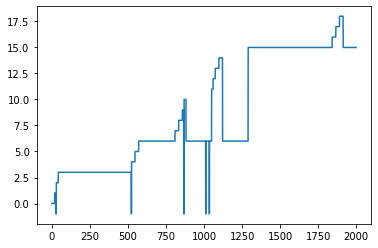

In [167]:
# не шум, но кластер со смыслом
ind_c= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_c[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

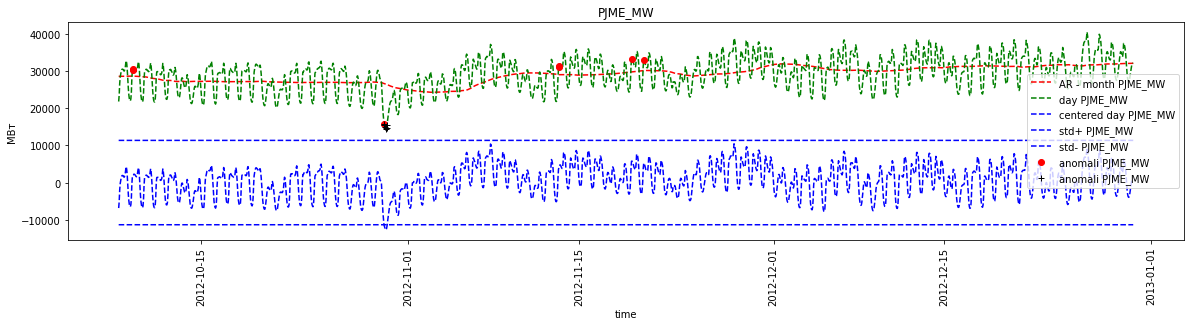

In [169]:
ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

# ind_anomal_c = np.array(ind_anomal_c)+p+2  


plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_anomal_c],diff_day[-51000:-49000].values[ind_anomal_c],'or',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'+k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

Добавили анализ по кластерам к анализу по статистике скользящих окон и видим совпадение точки для 30.10.2012. Можно расчитывать на то, что это аномалия. Однако проверим еще раз используя модель ряда.

In [170]:
data_week=data['PJME_MW'].resample("W").apply('mean')

np.where(data_week.index.weekofyear == pd.to_datetime('2012-10-30').weekofyear)[0]

array([ 43,  95, 147, 200, 252, 304, 356, 408, 461, 513, 565, 617, 669,
       721, 774, 826])

Сделаем ресемплинг, для ускорения работы модели на недельные отсчеты. Построим модель ряда по ARIMA (опираясь на результаты урока 2)

In [171]:
mod = sm.tsa.statespace.SARIMAX(data_week.values[200:560],order=[0,0,0],
                                seasonal_order=[2,0,0,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC:{results_opt.aic}')

AIC:4722.690984524124


In [174]:
pred_dynamic_opt

array([30134.67037226, 27230.26677864, 27567.11148233, 27281.17897183,
       27922.52425774, 28894.6459705 , 28614.40086145, 28739.87856525,
       28077.48753933, 30620.18923749, 32946.35240671, 34705.97962649,
       32703.08779417, 31483.78874809, 33856.48021754, 34411.75251985,
       35028.32836154, 33402.0411036 , 32679.24424248, 33582.89842762,
       30908.4248785 , 31296.95057278, 30253.57669207, 30015.5563799 ,
       27756.74613941, 28622.57011424, 28928.69099205, 27352.4069586 ,
       27080.43655417, 27102.41176088, 27761.11088003, 27061.26277049,
       26899.39060325, 27959.48700179, 32089.96826088, 33355.12538066])

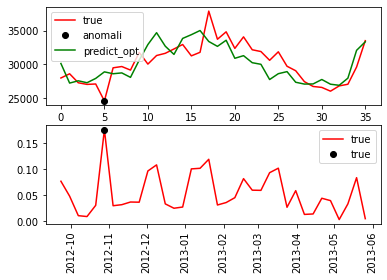

In [175]:
data_month = data_week.copy()  
pred_dynamic_opt = results_opt.forecast(12*3)
plt.subplot(2,1,1)
plt.plot( data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( 5,data_month.values[565], 'ok',label='anomali' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.legend()
plt.subplot(2,1,2)

plt.plot( data_month.index[560-1:560+12*3-1],np.abs(data_month.values[560:560+12*3]-pred_dynamic_opt)/data_month.values[560:560+12*3], 'r',label='true' )
plt.plot( data_month.index[565-1],np.abs(data_month.values[565]-pred_dynamic_opt[5])/data_month.values[565], 'ok',label='true' )
plt.xticks(rotation='90')
plt.legend()
plt.show()

Видно, что аномалия 2012.10.30 лежит на уровне больших ошибок. Это позволяет ее с хорошей вероятностью считать аномалией поведения ряда (на других участках ряда эта модель дает примерно одинаковые ошибки, а тут видим значительное возрастание ошибки на отрезке до 1 месяца). Таким образом подтверждена проблема ряда 30.10.2012.


Замечание:
Визуальный анализ и анализ уровней выявляет аномалию амплитуды, однако не выявит аномалии частотного типа. Для этого следует перейти не к статистикам ряда, а к методам частотного анализа (спектральным моделям анализа ряда, например).

**КАК ИСПОЛЬЗОВАТЬ АНОМАЛИИ:**
 - Построить набор примеров для классификации следующих аномалий.
 - Проверить модель на следующих интервалах, вдруг это не аномалия.

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [177]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

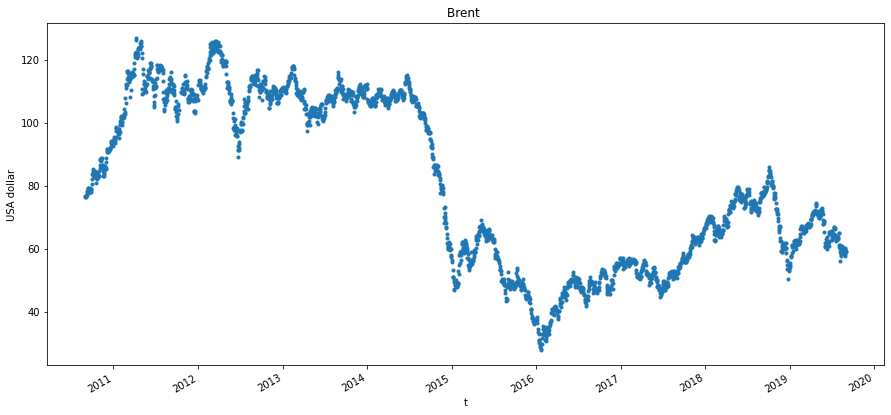

In [178]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

Помним, что наиболее интересным для и интерпретируемым у этого ряда является поведение его первых разностей
Построим их и посмотрим на аномалии этой части нашей модели.

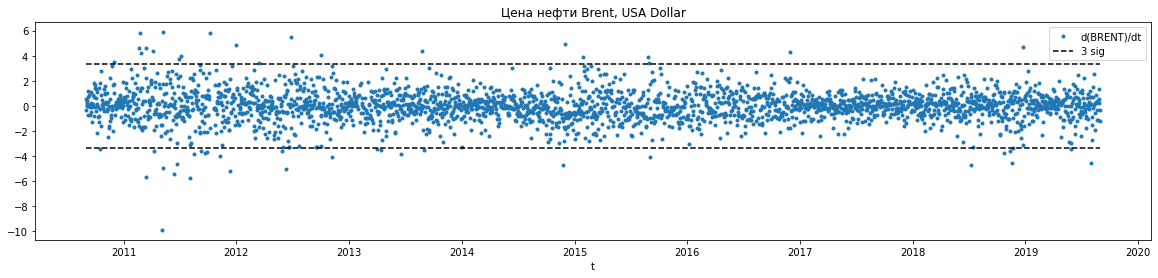

In [179]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data)**0.5 *3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]

Рис.4 BRENT первые разности

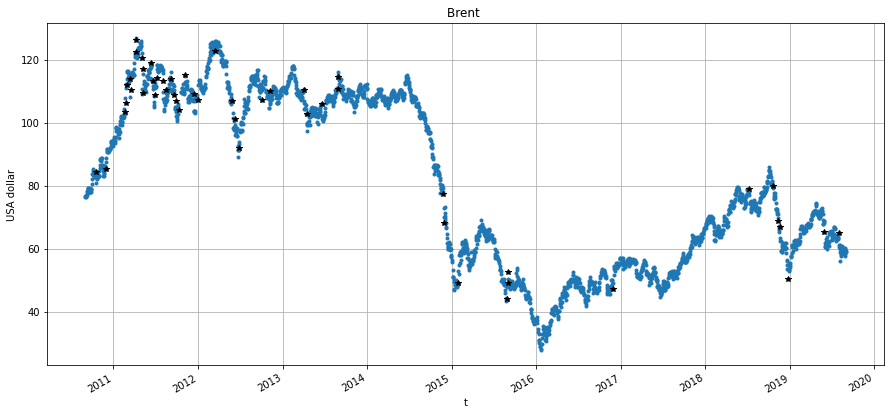

In [180]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'*k', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.show()

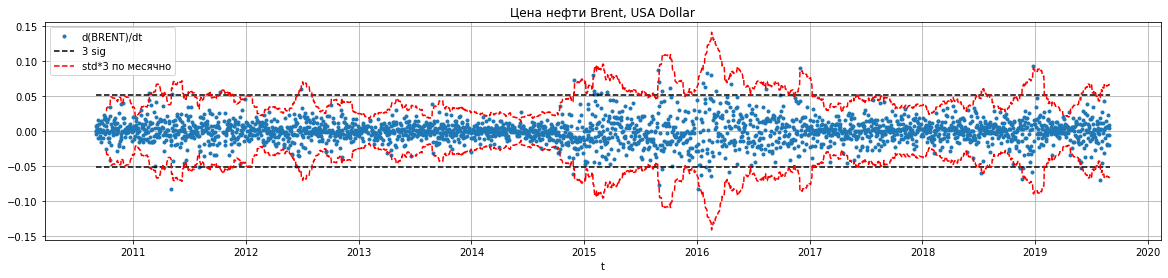

In [184]:
d_brent_data1 = (brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1])/brent_data['Значение'].values[:-1]
std_d_brent = pd.DataFrame(data=d_brent_data1,index =brent_data.index[1:] ).rolling(30).std()
s_brent1 = np.std(d_brent_data1)*3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(std_d_brent.index,std_d_brent*3,'--r',label = 'std*3 по месячно')
plt.plot(std_d_brent.index,-std_d_brent*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]
ind_anomal_brent2 = np.where( abs(d_brent_data1)>std_d_brent.values*3)[0]

In [185]:
brent_data.index[[0,-1]]

DatetimeIndex(['2010-09-01', '2019-09-01'], dtype='datetime64[ns]', name='Дата', freq=None)

In [196]:
len(set(ind_anomal_brent2))

2637

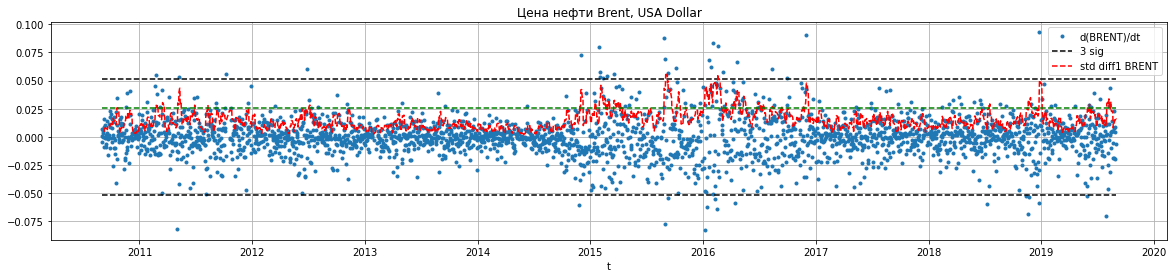

In [199]:
brent_diff1=pd.DataFrame(data=d_brent_data1, index=brent_data.index[1:])

brent_diff1_std=brent_diff1[0].rolling(7).std()
brent_diff_std=np.std(brent_diff1_std)*3

ind_anomal_brent2 = np.where( abs(brent_diff1_std)>brent_diff_std)[0]

plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(brent_diff1_std,'--r',label ='std diff1 BRENT')
plt.plot(brent_diff1_std.iloc[[0,-1]].index,[brent_diff_std,brent_diff_std],'--g')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

In [200]:
# brent_diff_std

In [191]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))


In [192]:
X = brent_data.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)


первый элемент кластера 0  :  [-0.17721153 -1.75698575  0.72500659 -1.11065221  0.44539858  0.63193593
  0.63776124 -1.33798808  5.91379514 -0.16553715 -0.17488451 -0.19246036
 -0.19219421 -0.19194461  0.00947192  0.00947192  0.00947192]
Число кластеров с масштабированием:  8
Число не кластеров:  20


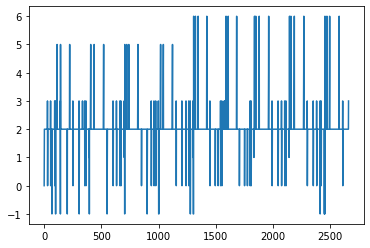

In [193]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Text(0.5, 0, 't')

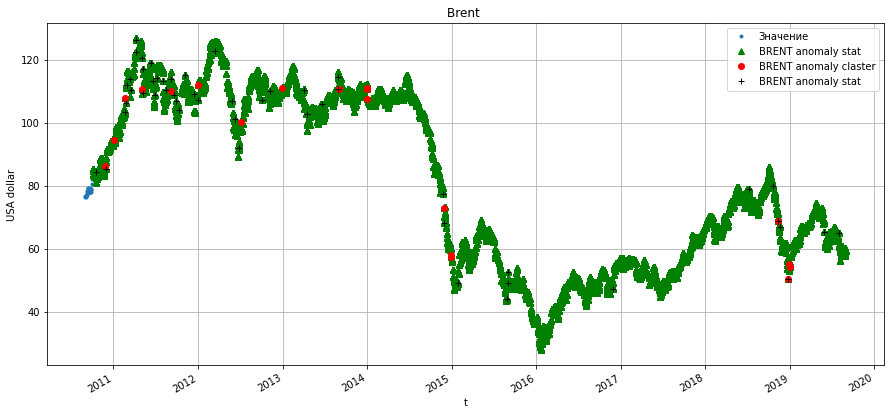

In [194]:
ind_anomal_brent_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_brent_c = np.array(ind_anomal_brent_c)+p+2  

_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent2].index,brent_data['Значение'].values[ind_anomal_brent2],'^g', label='BRENT anomaly stat')
plt.plot(brent_data.iloc[ind_anomal_brent_c].index,brent_data['Значение'].values[ind_anomal_brent_c],'or', label='BRENT anomaly claster')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'+k', label='BRENT anomaly stat')
plt.legend()
plt.grid()
plt.ylabel('USA dollar')
plt.xlabel('t')


Построили несколько кандидатов на аномальное поведение. Попробуем определить какой-нибудь дополнительный способ анализа.

## Генерация признаков  из внешних источников

Естественным попутчиком любого финансово -ориентированного ряда является кросс-курс валют. В случае BRENT патриотично рассматриваем кросс-курс доллар-рубль (стоимость доллара в рублях) и евро-рубль (стоимость евро в рублях). Интервал измерения стоимости доллара и евро соответствует частоте и периоду нашего ряда "стоимость нефти", а источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019, который позволяет сохранить результаты в нескольких различных вариантах. Прочитаем, сохраненные данные.

In [184]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [185]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


И сделаем их визуализацию.

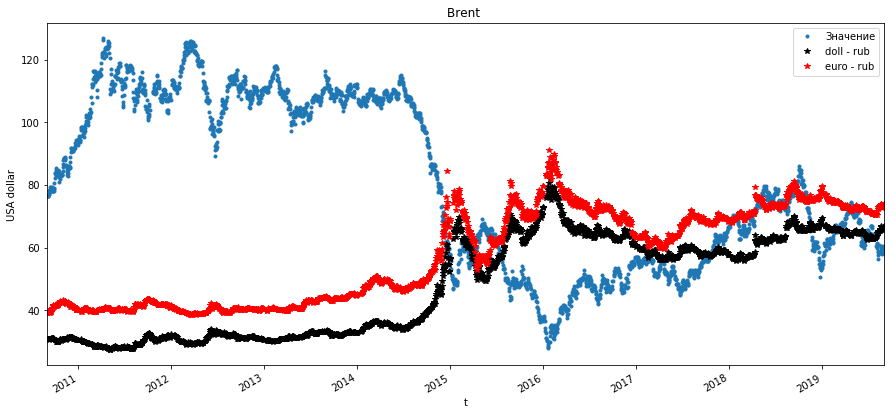

In [186]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.

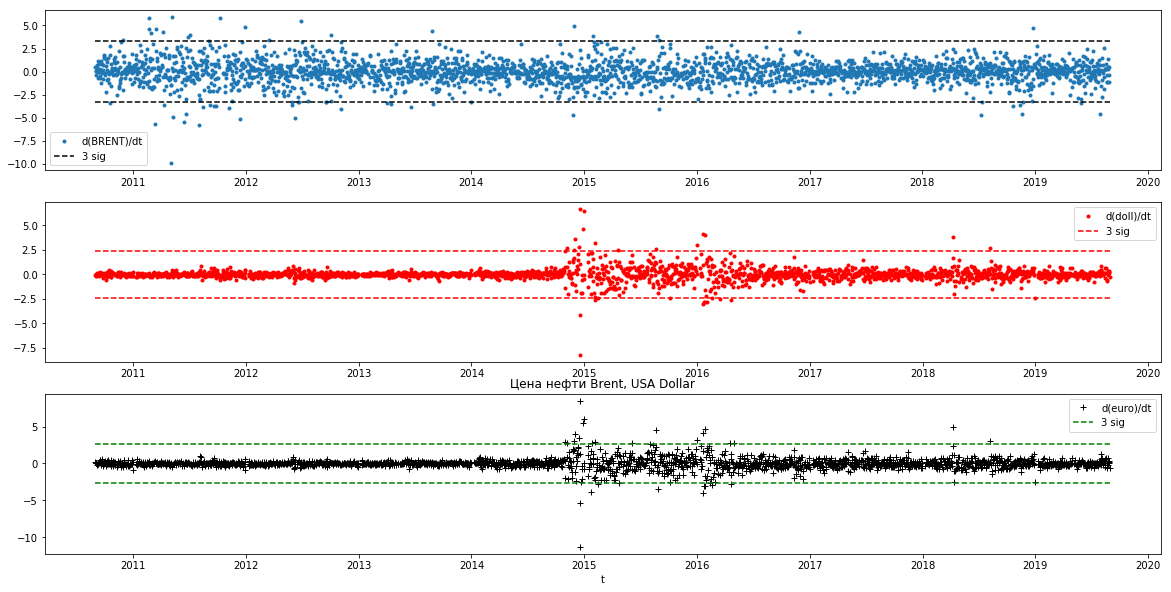

In [187]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

   


Сопоставим списки результатов, которые вышли за границы 3 сигма.

In [188]:
ind_anomal_brent

array([  41,   78,  146,  148,  153,  164,  166,  184,  186,  206,  209,
        211,  240,  247,  252,  259,  283,  295,  314,  325,  330,  340,
        357,  386,  399,  462,  525,  535,  551,  634,  663,  777,  787,
        844,  900,  904, 1282, 1285, 1335, 1494, 1496, 1497, 1818, 2311,
       2400, 2418, 2424, 2454, 2586, 2639], dtype=int64)

In [189]:
ind_anomal_rubl_d

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1096,
       1097, 1103, 1147, 1232, 1264, 1325, 1333, 1334, 1335, 1336, 1337,
       1343, 1353, 1370, 1393, 1881, 1964, 2066], dtype=int64)

In [190]:
ind_anomal_rubl_e

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1087,
       1089, 1096, 1103, 1149, 1176, 1232, 1235, 1325, 1333, 1334, 1335,
       1336, 1337, 1350, 1353, 1392, 1393, 1402, 1881, 1964], dtype=int64)

Есть пересечение всех трех множеств объект с номером 1335. Покажем этот и несколько соседних объектов (они сильно выпадают из ряда у кросс-курсов): 

In [191]:
rub_doll.index[[1333, 1334, 1335, 1336, 1337]]

Index([2016-01-21, 2016-01-22, 2016-01-23, 2016-01-26, 2016-01-27], dtype='object')

Проблема кросс-курса с рублем в том, что трудно сказать курс зависит от цены  нефти или цена от курса (но по логике экономики должен курс рубля зависеть от цены нефти). 2016 в январе курс к доллару составил 82 р (https://www.gazeta.ru/business/2016/01/20/8031815.shtml) на фоне резкого падения цены нефти (иранский фактор - сняли эмбарго на экспорт в начале января). Однако, если в некоторый день цена нефти и кросс-курс ведут себя разнонаправленно, то можно предположить. что это не глобальное явление, а некоторый случайный выброс. Декабрь 2015-январь 2016 - смена уровня , т.е. глобальное изменение ряда по типу аномалии "изменение характера (распределения) значений". В данном случае сильно изменяется средняя ряда.

Добавим стоимость валюты в рублях

In [192]:
brent_data['doll']=0
brent_data['doll'].values[1:2229]=rub_doll['curs'].values[:]
brent_data=brent_data.iloc[:2229,:]

В итоге данные примут вид 

In [193]:
brent_data.iloc[100:115,:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-12-27,93.71,2010,12,27,4,361,52,0,0,0,0,93,94,93,0,0,0,29
2010-12-28,94.21,2010,12,28,4,362,52,1,0,0,0,94,93,93,0,0,0,29
2010-12-29,94.03,2010,12,29,4,363,52,2,0,0,0,93,93,93,0,0,0,29
2010-12-30,92.71,2010,12,30,4,364,52,3,0,1,0,93,93,94,-1,-1,-1,29
2010-12-31,94.59,2010,12,31,4,365,52,4,1,0,0,93,94,94,1,1,1,29
2011-01-02,94.56,2011,1,2,1,2,52,6,0,0,0,94,94,92,0,0,0,29
2011-01-03,94.85,2011,1,3,1,3,1,0,0,0,0,94,92,94,0,0,0,29
2011-01-05,95.54,2011,1,5,1,5,1,2,0,0,0,92,94,94,0,0,0,29
2011-01-06,94.43,2011,1,6,1,6,1,3,0,0,0,94,94,94,-1,-1,-1,29


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [264]:
scl_target=StandardScaler() 

h=1
target = brent_data["Значение"].values[h:].reshape((brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(2228, 1)

In [265]:
scl_x=StandardScaler() 

X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(2228, 18)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

In [266]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=1107279.65,  I=0
F-test=3410.44,  I=1
F-test=0.58,  I=2
F-test=0.12,  I=3
F-test=0.44,  I=4
F-test=0.57,  I=5
F-test=0.56,  I=6
F-test=14.25,  I=7
F-test=0.29,  I=8
F-test=0.65,  I=9
F-test=0.23,  I=10
F-test=86245.01,  I=11
F-test=92446.32,  I=12
F-test=100202.39,  I=13
F-test=0.74,  I=14
F-test=0.74,  I=15
F-test=0.74,  I=16
F-test=3671.78,  I=17


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки 1 , 7, 11, 12, 13 и 17. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [267]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(2228, 5)

Лучшее множество признаков отделенов X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [268]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(2228, 2)

Наконец, третий вариант - применим выделение признаков через построение модели . Помним , что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [269]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(2228, 1)

Сравним результаты:


In [270]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.27057742, -2.94401205, -2.94377625, -2.94354051, -2.9980909 ],
        [-0.25201489, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26343799, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26165313, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26129616, -2.94401205, -2.94377625, -2.94354051, -1.10809584]]),
 array([[-0.27057742, -2.94354051],
        [-0.25201489, -2.94354051],
        [-0.26343799, -2.94354051],
        [-0.26165313, -2.94354051],
        [-0.26129616, -2.94354051]]),
 array([[-0.27057742],
        [-0.25201489],
        [-0.26343799],
        [-0.26165313],
        [-0.26129616]])]

In [271]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 13 17]
Номера признаков лучших признаков по процентной форме:  [ 0 13]
Номера признаков для выбора по модели :  [0]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,14,21] признаки и перейдем к построению модели.

In [272]:
X_new = X[:,[0,11,12,13,17]]


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [273]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 100 от конца

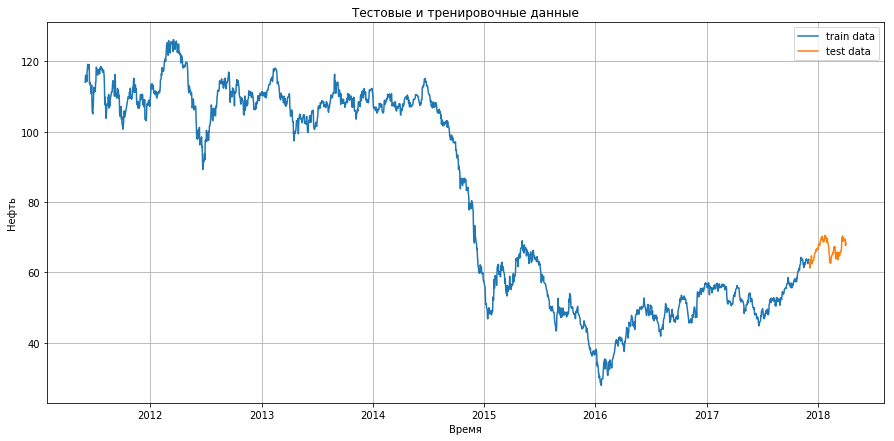

In [274]:
train, test = split_data( brent_data[-2000:], -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [275]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [276]:
train.shape

(1900, 18)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [277]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [278]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)
model_l = LinearRegression()

Запускаем модели и смотрим , что они построят на наших примерах.

In [279]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=10, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**Посмотрим тесты**

In [280]:
X_test.shape

(328, 5)

In [281]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

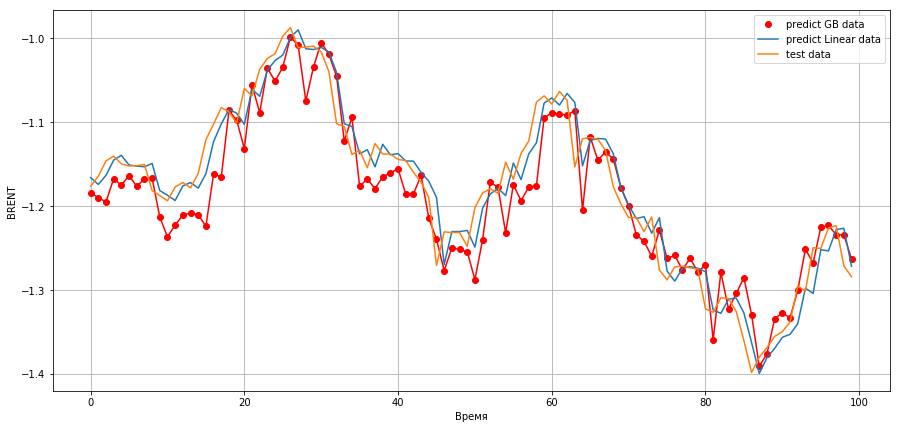

In [284]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g[:100],'or', label='predict GB data' )
plt.plot(y_test_pred_g[:100],'r' )
plt.plot(y_test_pred_l[:100], label='predict Linear data' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

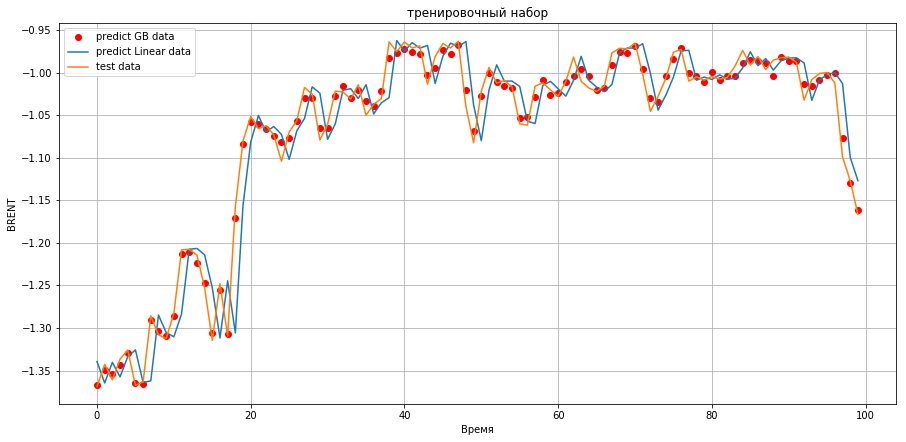

In [285]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g[-100:],'or', label='predict GB data' )
plt.plot(y_pred_l[-100:], label='predict Linear data' )
plt.plot(y_train[-100:], label='test data')
plt.grid()
plt.legend()
plt.show()

Линейная модель практически не работает, т.к. видно запаздывание в размере h.Градиентный бустинг практически не отличается от нее на интервале обучения. Посмотрим на оценки.

**Оценки для сравнения моделей**

In [286]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [287]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.0016213598004232806 
ошибка mae  :   0.03182573595459734 
оценка R2 :   0.9757230160056449


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Поэтому переведем ответ решателя обратно в состояние без масштаба.

In [288]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [289]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.5543343606193705 %


In [290]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.859 (std: 0.163)
Parameters: {'n_estimators': 400, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.857 (std: 0.165)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.856 (std: 0.171)
Parameters: {'n_estimators': 200, 'max_depth': 1}



In [291]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.154736923937579 %


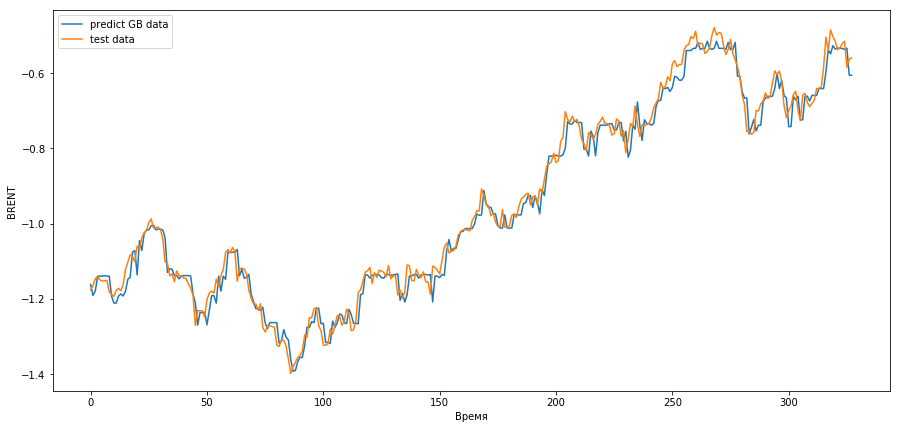

In [292]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

## Сохраниение модели

In [293]:
import pickle
# save the model to disk
filename = 'final_model_brent.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_brent_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_brent_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Следим за аномалиями



## Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.